# Test D3QN for Flappy Bird

In [44]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import deque
from collections import namedtuple
import typing
import flappy_bird_gym

In [45]:
class QNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations, 125),
            nn.ReLU(),
            nn.Linear(125,100),
            nn.ReLU(),
            nn.Linear(100, nb_actions)
        )
        
    def forward(self,x) :
        return self.net(x)

class DuelingQNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32)
        )
        
        self.net_advantage = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,nb_actions)
        )
        
        self.net_state_value = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,1)
        )
        
    def advantage(self,x) :
        return self.net_advantage(self.net(x))
    
    def state_value(self,x) :
        return self.net_state_value(self.net(x))
    
    def forward(self,x) :
        return self.state_value(x) + self.advantage(x) - torch.mean(self.advantage(x),dim=1).unsqueeze(1)

In [46]:
"""
Prioritized Experience Replay
"""


_field_names = [
    "state",
    "action",
    "reward",
    "done",
    "new_state"
    
]
Experience = namedtuple("Experience", field_names=_field_names)

class PrioritizedExperienceReplayBuffer:
    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return self._buffer_length

    def alpha(self):
        return self._alpha

    def batch_size(self) -> int:
        return self._batch_size
    
    def buffer_size(self) -> int:
        return self._buffer_size

    def add(self, experience: Experience) -> None:
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        experiences = self._buffer["experience"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        self._buffer["priority"][idxs] = priorities
        

def exponential_annealing_schedule(episode, rate=1e-2):
    return 1 - np.exp(-rate * episode)

In [47]:
def test(q_network) :
    state = env.reset()
    done = False
    cum_sum = 0
    timestep = 0
    while not done  :
        
        # state = np.append(state, env._game.player_vel_y)
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        timestep +=1
        
    return cum_sum

In [48]:
env = flappy_bird_gym.make("CartPole-v0")
nb_actions = 2
nb_observations = 4

In [67]:
nb_episode = 2000

discount_factor = 0.99
learning_rate = 2e-5
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1
tau = 1e-3 

In [68]:
replay_buffer = PrioritizedExperienceReplayBuffer(batch_size,size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_8 = []
timestep = 0

average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    # state = np.append(state, env._game.player_vel_y)
    done = False
    
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        # new_state = np.append(new_state, env._game.player_vel_y)
        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        
        replay_buffer.add(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            beta = exponential_annealing_schedule(episode)
            
            idxs, experiences, normalized_weights = replay_buffer.sample(beta)

            _sampling_weights = (torch.as_tensor(normalized_weights, dtype=torch.float32).view((-1, 1)))
            
            states, actions, rewards, dones ,new_states  = (vs for vs in zip(*experiences))

            states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in states]).squeeze()
            actions_t = torch.as_tensor(np.array([a for a in actions]) , dtype=torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(np.array([r for r in rewards]) , dtype=torch.float32).unsqueeze(1)
            dones_t = torch.as_tensor(np.array([o for o in dones] , dtype = int) , dtype=torch.int32).unsqueeze(1)
            new_states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in new_states]).squeeze()
            
            with torch.no_grad() :
                y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()
                td_error = y_target - torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            replay_buffer.update_priorities(idxs, td_error.abs().cpu().detach().numpy().flatten())
            
            mse = nn.MSELoss()
            q_values = torch.gather(q_network(states_t),dim=1,index=actions_t)
            loss =  mse(y_target*_sampling_weights ,q_values*_sampling_weights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t = test(q_network)
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_8.append(t)

  0%|▏                                         | 8/2000 [00:00<00:44, 44.33it/s]

episode 0 - test reward : 9.0 - avg : 10.0 - epsilon 0.995


  1%|▎                                        | 13/2000 [00:00<02:11, 15.14it/s]

episode 10 - test reward : 11.0 - avg : 9.363636363636363 - epsilon 0.946354579813443


  1%|▍                                        | 24/2000 [00:01<01:59, 16.56it/s]

episode 20 - test reward : 10.0 - avg : 9.666666666666666 - epsilon 0.9000874278732445


  2%|▋                                        | 34/2000 [00:02<01:56, 16.83it/s]

episode 30 - test reward : 10.0 - avg : 9.774193548387096 - epsilon 0.8560822709551227


  2%|▊                                        | 42/2000 [00:02<02:10, 14.96it/s]

episode 40 - test reward : 10.0 - avg : 9.902439024390244 - epsilon 0.8142285204175609


  3%|█                                        | 52/2000 [00:03<02:12, 14.75it/s]

episode 50 - test reward : 9.0 - avg : 10.019607843137255 - epsilon 0.7744209942832988


  3%|█▎                                       | 62/2000 [00:05<06:14,  5.17it/s]

episode 60 - test reward : 38.0 - avg : 13.21311475409836 - epsilon 0.736559652908221


  4%|█▍                                       | 71/2000 [00:06<04:08,  7.75it/s]

episode 70 - test reward : 28.0 - avg : 14.450704225352112 - epsilon 0.7005493475733617


  4%|█▋                                       | 81/2000 [00:08<06:41,  4.78it/s]

episode 80 - test reward : 26.0 - avg : 16.40740740740741 - epsilon 0.6662995813682115


  5%|█▉                                       | 92/2000 [00:10<07:33,  4.21it/s]

episode 90 - test reward : 28.0 - avg : 18.791208791208792 - epsilon 0.6337242817644086


  5%|██                                      | 102/2000 [00:12<05:32,  5.71it/s]

episode 100 - test reward : 35.0 - avg : 19.9 - epsilon 0.6027415843082742


  6%|██▏                                     | 111/2000 [00:14<06:56,  4.54it/s]

episode 110 - test reward : 32.0 - avg : 22.07 - epsilon 0.5732736268885887


  6%|██▍                                     | 122/2000 [00:16<05:11,  6.02it/s]

episode 120 - test reward : 32.0 - avg : 23.89 - epsilon 0.5452463540625918


  7%|██▋                                     | 132/2000 [00:18<05:44,  5.42it/s]

episode 130 - test reward : 32.0 - avg : 26.38 - epsilon 0.5185893309484582


  7%|██▊                                     | 140/2000 [00:19<04:13,  7.33it/s]

episode 140 - test reward : 40.0 - avg : 27.77 - epsilon 0.4932355662165453


  8%|███                                     | 153/2000 [00:21<04:20,  7.08it/s]

episode 150 - test reward : 25.0 - avg : 30.39 - epsilon 0.46912134373457726


  8%|███▎                                    | 163/2000 [00:24<04:51,  6.31it/s]

episode 160 - test reward : 43.0 - avg : 30.33 - epsilon 0.446186062443672


  9%|███▍                                    | 171/2000 [00:25<05:12,  5.85it/s]

episode 170 - test reward : 21.0 - avg : 30.66 - epsilon 0.42437208406280985


  9%|███▌                                    | 181/2000 [00:27<07:18,  4.15it/s]

episode 180 - test reward : 37.0 - avg : 30.9 - epsilon 0.4036245882390106


 10%|███▊                                    | 192/2000 [00:28<04:20,  6.94it/s]

episode 190 - test reward : 54.0 - avg : 29.47 - epsilon 0.38389143477919885


 10%|████                                    | 202/2000 [00:30<05:04,  5.91it/s]

episode 200 - test reward : 42.0 - avg : 28.66 - epsilon 0.36512303261753626


 11%|████▏                                   | 211/2000 [00:32<05:23,  5.54it/s]

episode 210 - test reward : 55.0 - avg : 28.91 - epsilon 0.3472722151889232


 11%|████▍                                   | 221/2000 [00:33<05:34,  5.32it/s]

episode 220 - test reward : 41.0 - avg : 28.43 - epsilon 0.3302941218954743


 12%|████▋                                   | 232/2000 [00:35<04:11,  7.03it/s]

episode 230 - test reward : 47.0 - avg : 26.96 - epsilon 0.3141460853680822


 12%|████▊                                   | 241/2000 [00:37<04:31,  6.48it/s]

episode 240 - test reward : 38.0 - avg : 27.14 - epsilon 0.2987875242397482


 13%|█████                                   | 252/2000 [00:39<05:28,  5.32it/s]

episode 250 - test reward : 67.0 - avg : 25.7 - epsilon 0.28417984116121187


 13%|█████▏                                  | 261/2000 [00:40<03:33,  8.15it/s]

episode 260 - test reward : 46.0 - avg : 25.13 - epsilon 0.2702863258025825


 14%|█████▍                                  | 271/2000 [00:42<05:33,  5.18it/s]

episode 270 - test reward : 40.0 - avg : 25.72 - epsilon 0.2570720625972084


 14%|█████▋                                  | 282/2000 [00:44<06:12,  4.61it/s]

episode 280 - test reward : 50.0 - avg : 25.58 - epsilon 0.24450384299593592


 15%|█████▊                                  | 292/2000 [00:45<03:39,  7.77it/s]

episode 290 - test reward : 13.0 - avg : 25.55 - epsilon 0.23255008201124722


 15%|██████                                  | 300/2000 [00:46<03:21,  8.45it/s]

episode 300 - test reward : 50.0 - avg : 25.68 - epsilon 0.2211807388415433


 16%|██████▏                                 | 312/2000 [00:48<05:22,  5.23it/s]

episode 310 - test reward : 54.0 - avg : 25.2 - epsilon 0.21036724137609603


 16%|██████▍                                 | 321/2000 [00:50<03:27,  8.08it/s]

episode 320 - test reward : 45.0 - avg : 24.91 - epsilon 0.2000824143909432


 17%|██████▋                                 | 332/2000 [00:51<03:45,  7.39it/s]

episode 330 - test reward : 60.0 - avg : 25.09 - epsilon 0.1903004112552766


 17%|██████▊                                 | 343/2000 [00:53<03:55,  7.02it/s]

episode 340 - test reward : 40.0 - avg : 25.55 - epsilon 0.18099664897669618


 18%|███████                                 | 351/2000 [00:54<02:43, 10.10it/s]

episode 350 - test reward : 31.0 - avg : 24.96 - epsilon 0.17214774642209296


 18%|███████▏                                | 361/2000 [00:55<03:44,  7.30it/s]

episode 360 - test reward : 54.0 - avg : 25.09 - epsilon 0.16373146555890544


 19%|███████▍                                | 373/2000 [00:56<02:54,  9.32it/s]

episode 370 - test reward : 13.0 - avg : 23.98 - epsilon 0.1557266555690826


 19%|███████▋                                | 383/2000 [00:57<02:21, 11.47it/s]

episode 380 - test reward : 12.0 - avg : 22.38 - epsilon 0.14811319969530845


 20%|███████▊                                | 391/2000 [00:58<02:58,  9.02it/s]

episode 390 - test reward : 63.0 - avg : 22.21 - epsilon 0.14087196468590776


 20%|████████                                | 402/2000 [01:00<03:24,  7.83it/s]

episode 400 - test reward : 43.0 - avg : 22.23 - epsilon 0.13398475271138335


 21%|████████▏                               | 412/2000 [01:01<02:42,  9.79it/s]

episode 410 - test reward : 57.0 - avg : 21.28 - epsilon 0.12743425563174798


 21%|████████▍                               | 421/2000 [01:02<03:55,  6.71it/s]

episode 420 - test reward : 14.0 - avg : 22.49 - epsilon 0.12120401149972035


 22%|████████▋                               | 432/2000 [01:04<04:34,  5.72it/s]

episode 430 - test reward : 53.0 - avg : 22.85 - epsilon 0.11527836319047392


 22%|████████▊                               | 442/2000 [01:05<03:14,  8.00it/s]

episode 440 - test reward : 43.0 - avg : 22.05 - epsilon 0.10964241905397228


 23%|█████████                               | 451/2000 [01:07<02:30, 10.30it/s]

episode 450 - test reward : 21.0 - avg : 22.67 - epsilon 0.1042820154910064


 23%|█████████▏                              | 462/2000 [01:08<02:36,  9.83it/s]

episode 460 - test reward : 12.0 - avg : 22.23 - epsilon 0.09918368135888474


 24%|█████████▍                              | 472/2000 [01:09<02:33,  9.95it/s]

episode 470 - test reward : 11.0 - avg : 22.36 - epsilon 0.0943346041173244


 24%|█████████▌                              | 481/2000 [01:10<02:56,  8.58it/s]

episode 480 - test reward : 15.0 - avg : 22.97 - epsilon 0.08972259762946533


 25%|█████████▊                              | 492/2000 [01:12<03:20,  7.51it/s]

episode 490 - test reward : 55.0 - avg : 23.05 - epsilon 0.08533607153708872


 25%|██████████                              | 503/2000 [01:14<04:02,  6.18it/s]

episode 500 - test reward : 34.0 - avg : 24.24 - epsilon 0.0811640021330769


 26%|██████████▏                             | 511/2000 [01:15<03:40,  6.75it/s]

episode 510 - test reward : 10.0 - avg : 24.45 - epsilon 0.07719590465791494


 26%|██████████▍                             | 522/2000 [01:16<04:02,  6.10it/s]

episode 520 - test reward : 10.0 - avg : 23.66 - epsilon 0.07342180695061275


 27%|██████████▋                             | 532/2000 [01:17<02:16, 10.72it/s]

episode 530 - test reward : 13.0 - avg : 22.78 - epsilon 0.06983222438783


 27%|██████████▊                             | 542/2000 [01:18<02:26,  9.98it/s]

episode 540 - test reward : 10.0 - avg : 22.45 - epsilon 0.06641813604822402


 28%|███████████                             | 552/2000 [01:20<02:42,  8.91it/s]

episode 550 - test reward : 11.0 - avg : 22.37 - epsilon 0.06317096204211972


 28%|███████████▎                            | 564/2000 [01:21<02:23,  9.97it/s]

episode 560 - test reward : 19.0 - avg : 22.27 - epsilon 0.06008254194952879


 29%|███████████▍                            | 573/2000 [01:22<02:28,  9.63it/s]

episode 570 - test reward : 11.0 - avg : 22.01 - epsilon 0.05714511431233153


 29%|███████████▋                            | 582/2000 [01:23<02:40,  8.84it/s]

episode 580 - test reward : 12.0 - avg : 22.07 - epsilon 0.0543512971290831


 30%|███████████▊                            | 591/2000 [01:24<02:24,  9.72it/s]

episode 590 - test reward : 12.0 - avg : 21.83 - epsilon 0.05169406930342616


 30%|████████████                            | 602/2000 [01:25<03:03,  7.61it/s]

episode 600 - test reward : 15.0 - avg : 20.6 - epsilon 0.04916675299948831


 31%|████████████▏                           | 612/2000 [01:27<02:47,  8.31it/s]

episode 610 - test reward : 27.0 - avg : 20.76 - epsilon 0.04676299685992172


 31%|████████████▍                           | 621/2000 [01:28<04:02,  5.69it/s]

episode 620 - test reward : 36.0 - avg : 20.67 - epsilon 0.04447676004441063


 32%|████████████▋                           | 632/2000 [01:31<03:50,  5.95it/s]

episode 630 - test reward : 10.0 - avg : 21.23 - epsilon 0.04230229704853423


 32%|████████████▊                           | 642/2000 [01:32<02:32,  8.90it/s]

episode 640 - test reward : 27.0 - avg : 21.23 - epsilon 0.04023414326483323


 33%|█████████████                           | 651/2000 [01:33<03:13,  6.96it/s]

episode 650 - test reward : 12.0 - avg : 21.72 - epsilon 0.03826710124979409


 33%|█████████████▏                          | 662/2000 [01:35<03:00,  7.41it/s]

episode 660 - test reward : 12.0 - avg : 21.58 - epsilon 0.036396227662238566


 34%|█████████████▍                          | 672/2000 [01:35<01:52, 11.80it/s]

episode 670 - test reward : 11.0 - avg : 21.69 - epsilon 0.03461682084029365


 34%|█████████████▋                          | 682/2000 [01:37<02:01, 10.83it/s]

episode 680 - test reward : 34.0 - avg : 21.43 - epsilon 0.032924408985721944


 34%|█████████████▊                          | 690/2000 [01:37<02:20,  9.32it/s]

episode 690 - test reward : 11.0 - avg : 21.61 - epsilon 0.03131473892591842


 35%|██████████████                          | 703/2000 [01:39<02:18,  9.38it/s]

episode 700 - test reward : 20.0 - avg : 21.89 - epsilon 0.029783765425331846


 36%|██████████████▏                         | 712/2000 [01:40<02:40,  8.01it/s]

episode 710 - test reward : 11.0 - avg : 22.06 - epsilon 0.02832764101944931


 36%|██████████████▍                         | 722/2000 [01:41<02:14,  9.48it/s]

episode 720 - test reward : 9.0 - avg : 21.27 - epsilon 0.02694270634579598


 37%|██████████████▌                         | 731/2000 [01:42<02:10,  9.74it/s]

episode 730 - test reward : 20.0 - avg : 21.44 - epsilon 0.02562548094765099


 37%|██████████████▊                         | 741/2000 [01:44<02:37,  7.99it/s]

episode 740 - test reward : 20.0 - avg : 22.15 - epsilon 0.02437265452736848


 38%|███████████████                         | 753/2000 [01:45<01:50, 11.32it/s]

episode 750 - test reward : 9.0 - avg : 21.39 - epsilon 0.023181078627322618


 38%|███████████████▏                        | 761/2000 [01:46<01:59, 10.37it/s]

episode 760 - test reward : 8.0 - avg : 21.57 - epsilon 0.022047758717570132


 39%|███████████████▍                        | 773/2000 [01:47<02:27,  8.34it/s]

episode 770 - test reward : 11.0 - avg : 22.61 - epsilon 0.020969846670345987


 39%|███████████████▋                        | 783/2000 [01:48<02:01, 10.05it/s]

episode 780 - test reward : 8.0 - avg : 22.85 - epsilon 0.02


 40%|███████████████▊                        | 792/2000 [01:49<02:05,  9.63it/s]

episode 790 - test reward : 18.0 - avg : 22.67 - epsilon 0.02


 40%|████████████████                        | 802/2000 [01:50<01:57, 10.17it/s]

episode 800 - test reward : 15.0 - avg : 21.94 - epsilon 0.02


 41%|████████████████▏                       | 811/2000 [01:51<01:57, 10.14it/s]

episode 810 - test reward : 27.0 - avg : 21.63 - epsilon 0.02


 41%|████████████████▍                       | 821/2000 [01:53<02:52,  6.83it/s]

episode 820 - test reward : 16.0 - avg : 22.36 - epsilon 0.02


 42%|████████████████▋                       | 832/2000 [01:55<03:41,  5.26it/s]

episode 830 - test reward : 27.0 - avg : 21.96 - epsilon 0.02


 42%|████████████████▊                       | 843/2000 [01:56<01:53, 10.23it/s]

episode 840 - test reward : 24.0 - avg : 21.06 - epsilon 0.02


 43%|█████████████████                       | 852/2000 [02:00<04:42,  4.06it/s]

episode 850 - test reward : 19.0 - avg : 21.78 - epsilon 0.02


 43%|█████████████████▏                      | 860/2000 [02:01<02:31,  7.54it/s]

episode 860 - test reward : 23.0 - avg : 21.5 - epsilon 0.02


 44%|█████████████████▍                      | 872/2000 [02:02<02:07,  8.85it/s]

episode 870 - test reward : 23.0 - avg : 20.28 - epsilon 0.02


 44%|█████████████████▋                      | 882/2000 [02:03<02:14,  8.32it/s]

episode 880 - test reward : 26.0 - avg : 20.43 - epsilon 0.02


 45%|█████████████████▊                      | 892/2000 [02:04<01:46, 10.43it/s]

episode 890 - test reward : 14.0 - avg : 20.48 - epsilon 0.02


 45%|██████████████████                      | 901/2000 [02:06<03:37,  5.05it/s]

episode 900 - test reward : 11.0 - avg : 20.37 - epsilon 0.02


 46%|██████████████████▏                     | 911/2000 [02:08<03:10,  5.72it/s]

episode 910 - test reward : 13.0 - avg : 20.46 - epsilon 0.02


 46%|██████████████████▍                     | 922/2000 [02:10<02:21,  7.62it/s]

episode 920 - test reward : 14.0 - avg : 20.51 - epsilon 0.02


 47%|██████████████████▌                     | 931/2000 [02:11<02:44,  6.49it/s]

episode 930 - test reward : 18.0 - avg : 20.86 - epsilon 0.02


 47%|██████████████████▊                     | 941/2000 [02:13<02:36,  6.78it/s]

episode 940 - test reward : 17.0 - avg : 21.58 - epsilon 0.02


 48%|███████████████████                     | 951/2000 [02:14<02:22,  7.36it/s]

episode 950 - test reward : 17.0 - avg : 21.6 - epsilon 0.02


 48%|███████████████████▏                    | 961/2000 [02:16<03:13,  5.38it/s]

episode 960 - test reward : 15.0 - avg : 22.68 - epsilon 0.02


 49%|███████████████████▍                    | 971/2000 [02:18<02:01,  8.44it/s]

episode 970 - test reward : 11.0 - avg : 23.06 - epsilon 0.02


 49%|███████████████████▋                    | 983/2000 [02:19<01:49,  9.30it/s]

episode 980 - test reward : 12.0 - avg : 22.75 - epsilon 0.02


 50%|███████████████████▊                    | 992/2000 [02:20<02:36,  6.43it/s]

episode 990 - test reward : 15.0 - avg : 22.66 - epsilon 0.02


 50%|███████████████████▌                   | 1002/2000 [02:22<02:40,  6.24it/s]

episode 1000 - test reward : 11.0 - avg : 23.67 - epsilon 0.02


 51%|███████████████████▋                   | 1012/2000 [02:23<02:08,  7.68it/s]

episode 1010 - test reward : 13.0 - avg : 23.3 - epsilon 0.02


 51%|███████████████████▉                   | 1020/2000 [02:24<01:24, 11.66it/s]

episode 1020 - test reward : 16.0 - avg : 22.69 - epsilon 0.02


 52%|████████████████████                   | 1032/2000 [02:26<01:56,  8.28it/s]

episode 1030 - test reward : 10.0 - avg : 23.19 - epsilon 0.02


 52%|████████████████████▎                  | 1042/2000 [02:27<02:03,  7.74it/s]

episode 1040 - test reward : 15.0 - avg : 22.67 - epsilon 0.02


 53%|████████████████████▍                  | 1051/2000 [02:28<01:53,  8.39it/s]

episode 1050 - test reward : 16.0 - avg : 22.01 - epsilon 0.02


 53%|████████████████████▋                  | 1062/2000 [02:29<01:42,  9.17it/s]

episode 1060 - test reward : 12.0 - avg : 21.36 - epsilon 0.02


 54%|████████████████████▉                  | 1071/2000 [02:30<02:07,  7.26it/s]

episode 1070 - test reward : 8.0 - avg : 21.34 - epsilon 0.02


 54%|█████████████████████                  | 1081/2000 [02:32<02:23,  6.41it/s]

episode 1080 - test reward : 18.0 - avg : 21.63 - epsilon 0.02


 55%|█████████████████████▎                 | 1092/2000 [02:33<02:03,  7.32it/s]

episode 1090 - test reward : 12.0 - avg : 22.07 - epsilon 0.02


 55%|█████████████████████▍                 | 1101/2000 [02:35<02:19,  6.46it/s]

episode 1100 - test reward : 11.0 - avg : 22.1 - epsilon 0.02


 56%|█████████████████████▋                 | 1112/2000 [02:36<01:59,  7.43it/s]

episode 1110 - test reward : 17.0 - avg : 22.47 - epsilon 0.02


 56%|█████████████████████▉                 | 1122/2000 [02:38<01:53,  7.72it/s]

episode 1120 - test reward : 13.0 - avg : 23.18 - epsilon 0.02


 57%|██████████████████████                 | 1131/2000 [02:39<01:29,  9.71it/s]

episode 1130 - test reward : 11.0 - avg : 22.22 - epsilon 0.02


 57%|██████████████████████▏                | 1141/2000 [02:40<01:41,  8.45it/s]

episode 1140 - test reward : 12.0 - avg : 22.77 - epsilon 0.02


 58%|██████████████████████▍                | 1153/2000 [02:41<01:53,  7.47it/s]

episode 1150 - test reward : 14.0 - avg : 23.18 - epsilon 0.02


 58%|██████████████████████▋                | 1162/2000 [02:43<01:57,  7.15it/s]

episode 1160 - test reward : 19.0 - avg : 23.66 - epsilon 0.02


 59%|██████████████████████▊                | 1173/2000 [02:44<01:18, 10.60it/s]

episode 1170 - test reward : 17.0 - avg : 23.38 - epsilon 0.02


 59%|███████████████████████                | 1183/2000 [02:45<01:20, 10.10it/s]

episode 1180 - test reward : 13.0 - avg : 23.3 - epsilon 0.02


 60%|███████████████████████▏               | 1192/2000 [02:46<01:24,  9.54it/s]

episode 1190 - test reward : 8.0 - avg : 22.92 - epsilon 0.02


 60%|███████████████████████▍               | 1202/2000 [02:47<01:26,  9.18it/s]

episode 1200 - test reward : 13.0 - avg : 22.13 - epsilon 0.02


 61%|███████████████████████▋               | 1213/2000 [02:48<01:33,  8.41it/s]

episode 1210 - test reward : 10.0 - avg : 21.67 - epsilon 0.02


 61%|███████████████████████▊               | 1222/2000 [02:50<02:31,  5.15it/s]

episode 1220 - test reward : 13.0 - avg : 21.9 - epsilon 0.02


 62%|████████████████████████               | 1232/2000 [02:51<01:21,  9.42it/s]

episode 1230 - test reward : 11.0 - avg : 21.99 - epsilon 0.02


 62%|████████████████████████▏              | 1241/2000 [02:52<01:03, 11.94it/s]

episode 1240 - test reward : 11.0 - avg : 21.21 - epsilon 0.02


 63%|████████████████████████▍              | 1253/2000 [02:53<01:15,  9.84it/s]

episode 1250 - test reward : 12.0 - avg : 21.06 - epsilon 0.02


 63%|████████████████████████▌              | 1262/2000 [02:54<01:14,  9.94it/s]

episode 1260 - test reward : 14.0 - avg : 20.4 - epsilon 0.02


 64%|████████████████████████▊              | 1272/2000 [02:55<01:05, 11.10it/s]

episode 1270 - test reward : 16.0 - avg : 20.26 - epsilon 0.02


 64%|████████████████████████▉              | 1282/2000 [02:56<01:01, 11.62it/s]

episode 1280 - test reward : 13.0 - avg : 19.72 - epsilon 0.02


 65%|█████████████████████████▏             | 1292/2000 [02:58<01:33,  7.59it/s]

episode 1290 - test reward : 16.0 - avg : 20.16 - epsilon 0.02


 65%|█████████████████████████▍             | 1303/2000 [02:59<01:17,  8.94it/s]

episode 1300 - test reward : 11.0 - avg : 21.19 - epsilon 0.02


 66%|█████████████████████████▌             | 1312/2000 [03:00<01:27,  7.86it/s]

episode 1310 - test reward : 10.0 - avg : 21.53 - epsilon 0.02


 66%|█████████████████████████▊             | 1322/2000 [03:02<01:03, 10.65it/s]

episode 1320 - test reward : 14.0 - avg : 20.97 - epsilon 0.02


 67%|█████████████████████████▉             | 1332/2000 [03:03<01:01, 10.95it/s]

episode 1330 - test reward : 13.0 - avg : 20.63 - epsilon 0.02


 67%|██████████████████████████▏            | 1342/2000 [03:04<01:20,  8.14it/s]

episode 1340 - test reward : 10.0 - avg : 20.78 - epsilon 0.02


 68%|██████████████████████████▍            | 1353/2000 [03:05<01:25,  7.53it/s]

episode 1350 - test reward : 14.0 - avg : 20.88 - epsilon 0.02


 68%|██████████████████████████▌            | 1361/2000 [03:06<01:02, 10.15it/s]

episode 1360 - test reward : 18.0 - avg : 20.59 - epsilon 0.02


 69%|██████████████████████████▊            | 1373/2000 [03:07<01:05,  9.57it/s]

episode 1370 - test reward : 13.0 - avg : 21.02 - epsilon 0.02


 69%|██████████████████████████▉            | 1382/2000 [03:08<01:17,  7.94it/s]

episode 1380 - test reward : 11.0 - avg : 21.79 - epsilon 0.02


 70%|███████████████████████████▏           | 1392/2000 [03:10<01:00, 10.00it/s]

episode 1390 - test reward : 13.0 - avg : 21.62 - epsilon 0.02


 70%|███████████████████████████▎           | 1402/2000 [03:11<00:53, 11.10it/s]

episode 1400 - test reward : 11.0 - avg : 20.48 - epsilon 0.02


 71%|███████████████████████████▌           | 1412/2000 [03:12<01:09,  8.45it/s]

episode 1410 - test reward : 11.0 - avg : 20.28 - epsilon 0.02


 71%|███████████████████████████▋           | 1422/2000 [03:13<01:08,  8.45it/s]

episode 1420 - test reward : 11.0 - avg : 20.23 - epsilon 0.02


 72%|███████████████████████████▉           | 1432/2000 [03:14<00:59,  9.48it/s]

episode 1430 - test reward : 10.0 - avg : 20.61 - epsilon 0.02


 72%|████████████████████████████           | 1442/2000 [03:15<00:53, 10.42it/s]

episode 1440 - test reward : 21.0 - avg : 20.77 - epsilon 0.02


 73%|████████████████████████████▎          | 1452/2000 [03:16<01:08,  7.98it/s]

episode 1450 - test reward : 11.0 - avg : 20.78 - epsilon 0.02


 73%|████████████████████████████▌          | 1463/2000 [03:17<01:05,  8.25it/s]

episode 1460 - test reward : 16.0 - avg : 21.58 - epsilon 0.02


 74%|████████████████████████████▋          | 1472/2000 [03:18<00:52, 10.14it/s]

episode 1470 - test reward : 17.0 - avg : 21.2 - epsilon 0.02


 74%|████████████████████████████▉          | 1482/2000 [03:20<01:02,  8.26it/s]

episode 1480 - test reward : 12.0 - avg : 21.25 - epsilon 0.02


 75%|█████████████████████████████          | 1492/2000 [03:21<00:48, 10.48it/s]

episode 1490 - test reward : 20.0 - avg : 20.72 - epsilon 0.02


 75%|█████████████████████████████▎         | 1502/2000 [03:22<01:08,  7.26it/s]

episode 1500 - test reward : 10.0 - avg : 21.14 - epsilon 0.02


 76%|█████████████████████████████▌         | 1513/2000 [03:23<00:53,  9.11it/s]

episode 1510 - test reward : 16.0 - avg : 21.25 - epsilon 0.02


 76%|█████████████████████████████▋         | 1522/2000 [03:24<01:16,  6.27it/s]

episode 1520 - test reward : 14.0 - avg : 21.84 - epsilon 0.02


 77%|█████████████████████████████▊         | 1532/2000 [03:25<00:52,  9.00it/s]

episode 1530 - test reward : 12.0 - avg : 21.7 - epsilon 0.02


 77%|██████████████████████████████         | 1543/2000 [03:27<00:46,  9.84it/s]

episode 1540 - test reward : 16.0 - avg : 22.6 - epsilon 0.02


 78%|██████████████████████████████▎        | 1552/2000 [03:28<00:47,  9.50it/s]

episode 1550 - test reward : 12.0 - avg : 22.19 - epsilon 0.02


 78%|██████████████████████████████▍        | 1562/2000 [03:29<00:51,  8.51it/s]

episode 1560 - test reward : 14.0 - avg : 21.92 - epsilon 0.02


 79%|██████████████████████████████▋        | 1572/2000 [03:30<00:51,  8.37it/s]

episode 1570 - test reward : 10.0 - avg : 22.32 - epsilon 0.02


 79%|██████████████████████████████▊        | 1582/2000 [03:32<00:57,  7.31it/s]

episode 1580 - test reward : 15.0 - avg : 22.07 - epsilon 0.02


 80%|███████████████████████████████        | 1592/2000 [03:33<00:57,  7.10it/s]

episode 1590 - test reward : 10.0 - avg : 22.09 - epsilon 0.02


 80%|███████████████████████████████▏       | 1602/2000 [03:35<00:58,  6.76it/s]

episode 1600 - test reward : 13.0 - avg : 22.02 - epsilon 0.02


 80%|███████████████████████████████▍       | 1610/2000 [03:37<02:19,  2.80it/s]

episode 1610 - test reward : 12.0 - avg : 22.07 - epsilon 0.02


 81%|███████████████████████████████▋       | 1622/2000 [03:38<00:43,  8.61it/s]

episode 1620 - test reward : 14.0 - avg : 21.6 - epsilon 0.02


 82%|███████████████████████████████▊       | 1631/2000 [03:39<00:45,  8.03it/s]

episode 1630 - test reward : 14.0 - avg : 21.73 - epsilon 0.02


 82%|████████████████████████████████       | 1643/2000 [03:41<00:36,  9.70it/s]

episode 1640 - test reward : 12.0 - avg : 20.84 - epsilon 0.02


 83%|████████████████████████████████▏      | 1652/2000 [03:42<00:46,  7.42it/s]

episode 1650 - test reward : 12.0 - avg : 20.72 - epsilon 0.02


 83%|████████████████████████████████▍      | 1661/2000 [03:45<01:37,  3.47it/s]

episode 1660 - test reward : 14.0 - avg : 21.2 - epsilon 0.02


 84%|████████████████████████████████▌      | 1673/2000 [03:46<00:33,  9.85it/s]

episode 1670 - test reward : 15.0 - avg : 20.55 - epsilon 0.02


 84%|████████████████████████████████▊      | 1683/2000 [03:47<00:30, 10.45it/s]

episode 1680 - test reward : 9.0 - avg : 19.99 - epsilon 0.02


 85%|████████████████████████████████▉      | 1691/2000 [03:48<00:29, 10.50it/s]

episode 1690 - test reward : 12.0 - avg : 19.77 - epsilon 0.02


 85%|█████████████████████████████████▏     | 1703/2000 [03:50<00:34,  8.57it/s]

episode 1700 - test reward : 13.0 - avg : 20.07 - epsilon 0.02


 86%|█████████████████████████████████▍     | 1713/2000 [03:51<00:30,  9.53it/s]

episode 1710 - test reward : 11.0 - avg : 19.98 - epsilon 0.02


 86%|█████████████████████████████████▌     | 1722/2000 [03:53<00:39,  6.95it/s]

episode 1720 - test reward : 14.0 - avg : 20.04 - epsilon 0.02


 87%|█████████████████████████████████▊     | 1731/2000 [03:54<00:30,  8.72it/s]

episode 1730 - test reward : 13.0 - avg : 19.93 - epsilon 0.02


 87%|█████████████████████████████████▉     | 1740/2000 [03:55<00:30,  8.65it/s]

episode 1740 - test reward : 10.0 - avg : 19.88 - epsilon 0.02


 88%|██████████████████████████████████▏    | 1752/2000 [03:57<00:39,  6.23it/s]

episode 1750 - test reward : 19.0 - avg : 21.46 - epsilon 0.02


 88%|██████████████████████████████████▎    | 1762/2000 [03:58<00:37,  6.37it/s]

episode 1760 - test reward : 27.0 - avg : 20.94 - epsilon 0.02


 89%|██████████████████████████████████▌    | 1772/2000 [04:00<00:30,  7.38it/s]

episode 1770 - test reward : 17.0 - avg : 21.13 - epsilon 0.02


 89%|██████████████████████████████████▋    | 1781/2000 [04:01<00:24,  8.87it/s]

episode 1780 - test reward : 21.0 - avg : 21.33 - epsilon 0.02


 90%|██████████████████████████████████▉    | 1793/2000 [04:02<00:24,  8.38it/s]

episode 1790 - test reward : 11.0 - avg : 21.96 - epsilon 0.02


 90%|███████████████████████████████████▏   | 1802/2000 [04:03<00:22,  8.64it/s]

episode 1800 - test reward : 11.0 - avg : 21.44 - epsilon 0.02


 91%|███████████████████████████████████▎   | 1812/2000 [04:04<00:21,  8.66it/s]

episode 1810 - test reward : 13.0 - avg : 21.7 - epsilon 0.02


 91%|███████████████████████████████████▌   | 1822/2000 [04:05<00:17,  9.89it/s]

episode 1820 - test reward : 14.0 - avg : 21.5 - epsilon 0.02


 92%|███████████████████████████████████▋   | 1833/2000 [04:07<00:21,  7.92it/s]

episode 1830 - test reward : 19.0 - avg : 22.07 - epsilon 0.02


 92%|███████████████████████████████████▉   | 1842/2000 [04:08<00:16,  9.63it/s]

episode 1840 - test reward : 16.0 - avg : 21.92 - epsilon 0.02


 93%|████████████████████████████████████▏  | 1853/2000 [04:09<00:15,  9.39it/s]

episode 1850 - test reward : 17.0 - avg : 20.66 - epsilon 0.02


 93%|████████████████████████████████████▎  | 1861/2000 [04:10<00:17,  7.88it/s]

episode 1860 - test reward : 13.0 - avg : 20.71 - epsilon 0.02


 94%|████████████████████████████████████▍  | 1871/2000 [04:11<00:17,  7.34it/s]

episode 1870 - test reward : 11.0 - avg : 21.5 - epsilon 0.02


 94%|████████████████████████████████████▋  | 1883/2000 [04:13<00:12,  9.03it/s]

episode 1880 - test reward : 10.0 - avg : 21.95 - epsilon 0.02


 95%|████████████████████████████████████▉  | 1892/2000 [04:14<00:10, 10.52it/s]

episode 1890 - test reward : 14.0 - avg : 21.53 - epsilon 0.02


 95%|█████████████████████████████████████  | 1902/2000 [04:15<00:11,  8.91it/s]

episode 1900 - test reward : 13.0 - avg : 21.75 - epsilon 0.02


 96%|█████████████████████████████████████▎ | 1912/2000 [04:16<00:09,  9.56it/s]

episode 1910 - test reward : 13.0 - avg : 21.28 - epsilon 0.02


 96%|█████████████████████████████████████▍ | 1921/2000 [04:17<00:09,  8.26it/s]

episode 1920 - test reward : 14.0 - avg : 21.34 - epsilon 0.02


 97%|█████████████████████████████████████▋ | 1932/2000 [04:19<00:08,  8.36it/s]

episode 1930 - test reward : 12.0 - avg : 21.09 - epsilon 0.02


 97%|█████████████████████████████████████▊ | 1942/2000 [04:20<00:06,  8.50it/s]

episode 1940 - test reward : 12.0 - avg : 21.7 - epsilon 0.02


 98%|██████████████████████████████████████ | 1953/2000 [04:21<00:04, 10.39it/s]

episode 1950 - test reward : 12.0 - avg : 21.88 - epsilon 0.02


 98%|██████████████████████████████████████▎| 1962/2000 [04:23<00:04,  8.12it/s]

episode 1960 - test reward : 12.0 - avg : 21.74 - epsilon 0.02


 99%|██████████████████████████████████████▍| 1973/2000 [04:24<00:02,  9.16it/s]

episode 1970 - test reward : 11.0 - avg : 21.67 - epsilon 0.02


 99%|██████████████████████████████████████▋| 1982/2000 [04:25<00:02,  6.10it/s]

episode 1980 - test reward : 15.0 - avg : 21.7 - epsilon 0.02


100%|██████████████████████████████████████▊| 1992/2000 [04:27<00:01,  7.09it/s]

episode 1990 - test reward : 10.0 - avg : 22.61 - epsilon 0.02


100%|███████████████████████████████████████| 2000/2000 [04:28<00:00,  7.44it/s]


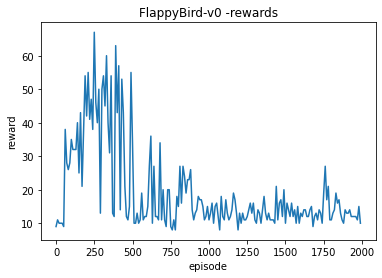

In [69]:
plt.figure()
plt.title("FlappyBird-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_8)
plt.show()